# Jordobservasjon med Sentinel-2 i Python

Dette er et Jupyter Notebok med eksempler for hvordan man kan bruke Python til jordobservasjon med data fra Sentinel-2 satellitt.

Sentinel-2 er en optisk satellitt, dvs. den tar regelmessige bilder av jordoverflaten som kan brukes for å holde øye med ting som skjer på bakken. Sensoren i Sentinel-2 ligner på en måte på kameraer vi bruker ellers, bare at den har flere kanaler. Dvs. den kan fange opp bølgelengder av lys-stråling som vi menesker ikke kan se med det blåtte øyet. Det gjør at data kan brukes spesielt godt for analyse av bla. arealdekke og vegetasjon.

Gjennom det så kalte Copernicus programm gjør det Europeiske Romsenter (European Space Agency - ESA) Sentinel-2 data tilgjengelig for allmenheten uten ekstra kostnad. I Norge er det Meteorologisk Institutt (met.no) som leverer data over norske interesseområder via Norsk Bakkesegment (satellittdata.no). Dette finansieres av Nork Romsenter.

I NVE bruker vi Sentinel-satelittene til mange ulike formål, som for eksempel overvåking av snødekke, flom og skred.

I dette eksemplet går vi gjennom følgende steg:

1) Finne Sentinel-2 bilder for et valgt område ved hjelp av geografiske koordinater
2) Lese data fra utvalgte scener og legge de inn i et kart
3) Beregne en Vegetasjonsindeks (NDVI) og Vannindeks (NDWI) fra Satellittbilde med Numpy
4) Beregne endring i indeksene mellom to tidspunkter (før og etter en hendelse)
5) Legge resutatene inn i kartet

Eksemplene er samlet i en Jupyter Notebook som er en teknologi som kombinerer kode, tekst og illustrasjon. Det er veldig mye brukt i datavitenskap. Binder er en plattform som gjør Jupyter notebooks tilgjengelig sammen med et definert kjøremiljø, dvs. med programvarebiblioteker som funksjoner som skal brukes i selve Jupyter Notebook tilgjengelig.
Ressursene i MyBinder plattformen er imidlertid begrenset og Satellittbilder krever i utgangspunkt relativt store ressurser. Vi fokusserer derfor på mindre utsnitt. Hvis noen velger større områder er det helt greit, men det kan føre til at systemet slutter å virke fordi de tilgjengelige ressursene er brukt opp...

Vi bruker my modulene:

leafmap: https://leafmap.org/notebooks/64_stac_search/

rasterio: https://rasterio.readthedocs.io/en/stable/index.html

numpy: https://numpy.org/

In [97]:
# Vi starter med å importere biblioteker vi trenger for å kjøre 
from pathlib import Path
import rasterio
import numpy as np
from osgeo import gdal, osr
from rasterio.enums import Resampling
from rasterio.plot import show
from rasterio.windows import Window


In [100]:
# Så definerer vi funksjoner som utfører oppgaver vi trenger å gjøre gjentatte ganger

def read_raster_window(url, lat_lon_bounds):
    """Read a window from a raster with rasterio."""
    s_srs = osr.SpatialReference()
    s_srs.ImportFromEPSG(4326)

    w = np.min(lat_lon_bounds[0:2])
    e = np.max(lat_lon_bounds[0:2])
    s = np.min(lat_lon_bounds[2:4])
    n = np.max(lat_lon_bounds[2:4])

    with rasterio.open(url) as src:
        t_srs = osr.SpatialReference()
        t_srs.ImportFromWkt(src.crs.to_wkt())
        transform = osr.CoordinateTransformation(s_srs, t_srs)
        src_bounds = transform.TransformPoints([[s,w,0], [n,e,0]])
        window_n = np.min([src_bounds[1][1], src.bounds.top])
        window_s = np.max([src_bounds[0][1], src.bounds.bottom])
        window_e = np.min([src_bounds[1][0], src.bounds.right])
        window_w = np.max([src_bounds[0][0], src.bounds.left])
        if not any([
            src.bounds.bottom > window_n,
            src.bounds.top < window_s,
            src.bounds.right > window_w,
            src.bounds.left >= window_e,
            ]):
            raise ValueError("Bounds are outside of the raster.")
        y_offset = np.ceil((src.bounds.top - window_n) / src.res[1])
        x_offset = np.floor((window_w - src.bounds.left) / src.res[0])
        width = np.ceil((window_e - window_w) / src.res[0])
        height = np.ceil((window_n - window_s) / src.res[1])
        window = Window(x_offset, y_offset, width, height)
        return src.read(1, window=window), src.crs, src.transform, window


def search_stac(lat_lon_bounds, time_range, max_cloud_cover):
    bbox = [np.min(lat_lon_bounds[0:2]), np.min(lat_lon_bounds[2:4]), np.max(lat_lon_bounds[0:2]), np.max(lat_lon_bounds[2:4])]
    url = "https://earth-search.aws.element84.com/v1/"
    collection = "sentinel-2-l2a"

    return leafmap.stac_search(
        url=url,
        max_items=5,
        collections=[collection],
        bbox=bbox,
        datetime=time_range,
        query={"eo:cloud_cover": {"lt": max_cloud_cover}},
        get_collection=True,
    )

In [ ]:
# Så definerer vi noen variabler
bands = ["red", "green", "blue", "nir", "swir16"]

In [66]:
lat_lon_bounds_aal = (8.40343, 8.61065, 60.56414, 60.66836)
time_before = "2023-06-01/2024-06-30"
time_after = "2024-06-19/2024-06-23"
max_cloud_cover = 20
lat_lon_bounds = bbox_aal

In [86]:
search = search_stac(lat_lon_bounds_aal, time_before, 10)

In [101]:
images = {}
for b in bands:
    url = list(search.items)[0].get_assets()[b].href
    if b == "red":
        images[b], src_crs, src_transform, window = read_raster_window(f"/vsicurl/{url}", lat_lon_bounds)
    else:
        images[b] = read_raster_window(f"/vsicurl/{url}", lat_lon_bounds)[0]

In [102]:
ndvi = (images["nir"].astype(float) - images["red"].astype(float)) / (images["nir"].astype(float) + images["red"].astype(float))

# ndsi = (images["swir16"].astype(float) - images["green"].astype(float)) / (images["swir16"].astype(float) + images["green"].astype(float))

#ndwi = (images["nir"].astype(float) - images["swir16"].astype(float)) / (images["nir"].astype(float) + images["swir16"].astype(float))

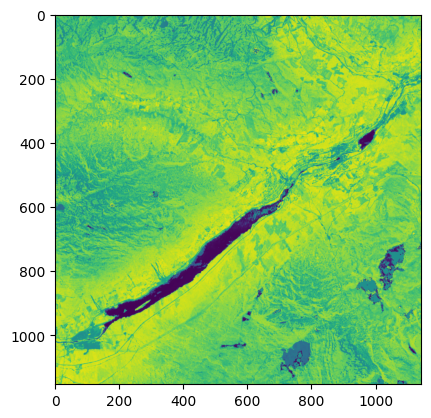

<Axes: >

In [103]:
from rasterio.plot import show
show(ndvi)

In [20]:
with rasterio.open(
        '/tmp/example.tif', 'w',
        crs=src_crs,
        driver='COG', width=images["red"].shape[0], height=images["red"].shape[0], count=3,
        dtype=images["red"].dtype,
        transform=rasterio.windows.transform(window, src_transform)) as dst:
    for k, arr in [(1, images["blue"]), (2, images["green"]), (3, images["red"])]:
        dst.write(arr, indexes=k)

In [25]:

lat_lon_bounds = lat_lon_bounbds_aal
bbox = [np.min(lat_lon_bounds[0:2]), np.min(lat_lon_bounds[2:4]), np.max(lat_lon_bounds[0:2]), np.max(lat_lon_bounds[2:4])]
center = [np.mean(lat_lon_bounds[2:4]), np.mean(lat_lon_bounds[0:2])]

catalogs = {
    "Element84 Earth Search": "https://earth-search.aws.element84.com/v1",
    "Microsoft Planetary Computer": "https://planetarycomputer.microsoft.com/api/stac/v1",
}

m = leafmap.Map(center=center, zoom=12, catalog_source=catalogs)

# ndvi_image = leafmap.array_to_image(ndvi, source=images["red"])
m.add_raster('/tmp/example.tif', layer_name="Sentinel-2")
m

Map(center=[59.850211, 11.0038865], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…